Accelerating computations with field-line mapping
=================================================

This examples highlights some ways to accelerate your calculations with field line mapping. We will use a W7-X case.

In [1]:
import fusionsc as fsc
from fusionsc.devices import w7x
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fsc.resolve.importOfflineData("../../w7x-op21.fsc")

In [3]:
grid = fsc.capnp.clone(w7x.defaultGrid)
grid.nR = 128
grid.nZ = 128
grid.nPhi = 32

In [ ]:
field = w7x.standard()
field = field + fsc.flt.axisCurrent(field, 10000, grid, startPoint = [6, 0, 0], direction = "cw")
field = field.compute(grid)

Preparing the mapping
---------------------

To prepare the mapping, we need to specify the planes in which we want the remapping to occur.

In [12]:
mapping = fsc.flt.computeMapping(
    field,
    np.radians(72 * np.arange(0, 5)),
    r = np.linspace(4, 7, 200),
    z = np.linspace(-1.5, 1.5, 200),
    stepSize = 0.01,
    distanceLimit = 7 * 2 * np.pi / 8
)

In [4]:
geoGrid = w7x.defaultGeometryGrid
geometry = w7x.divertor('OP21').index(geoGrid)

In [5]:
field = fsc.magnetics.MagneticConfig.load("field.fsc")

In [6]:
mapping = fsc.data.openArchive("mapping.fsc")

After calculating the mapping, we can take a look at the structure of the generated mapping planes.

In [13]:
mData = fsc.data.download(mapping)

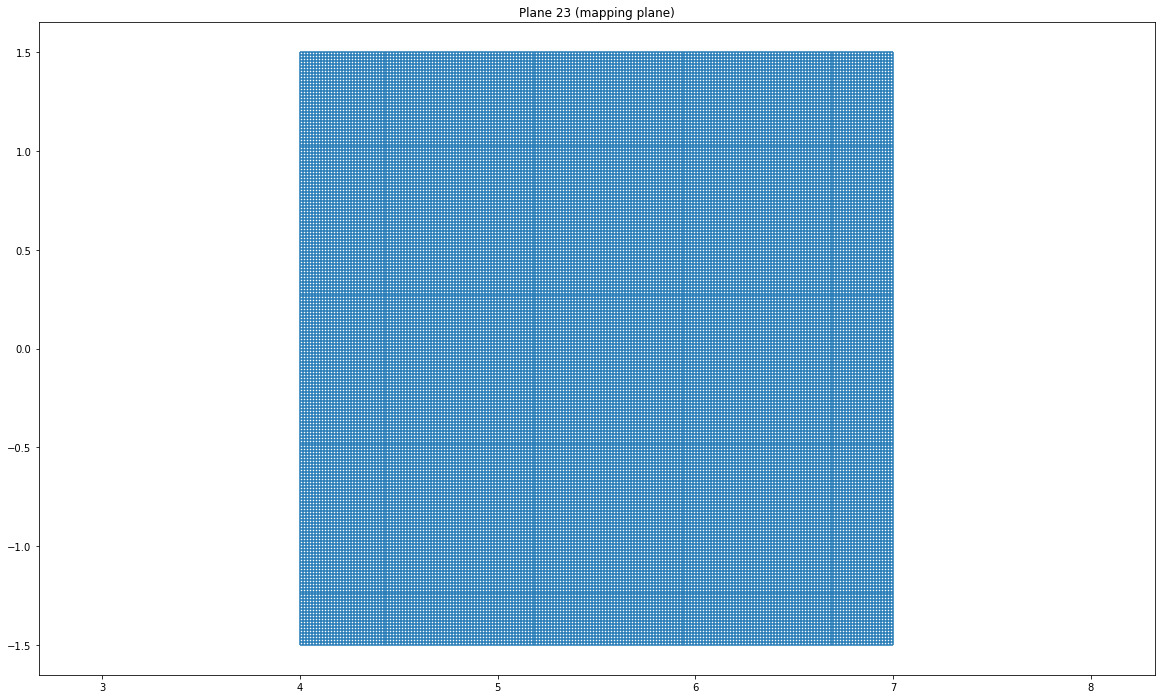

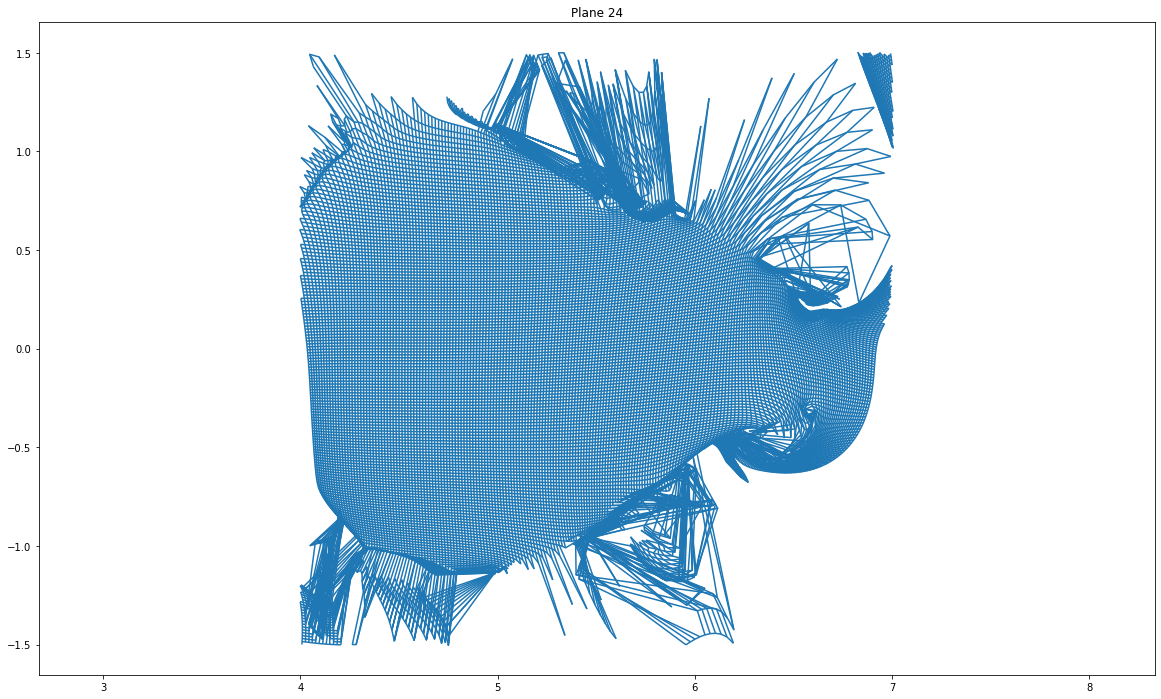

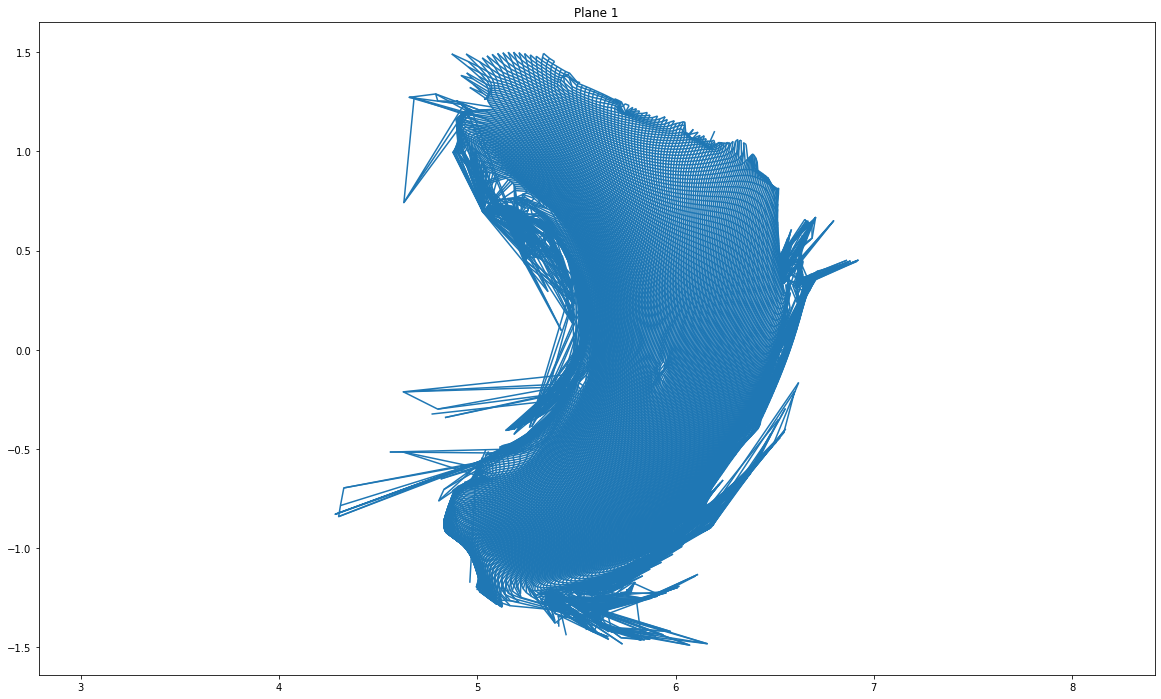

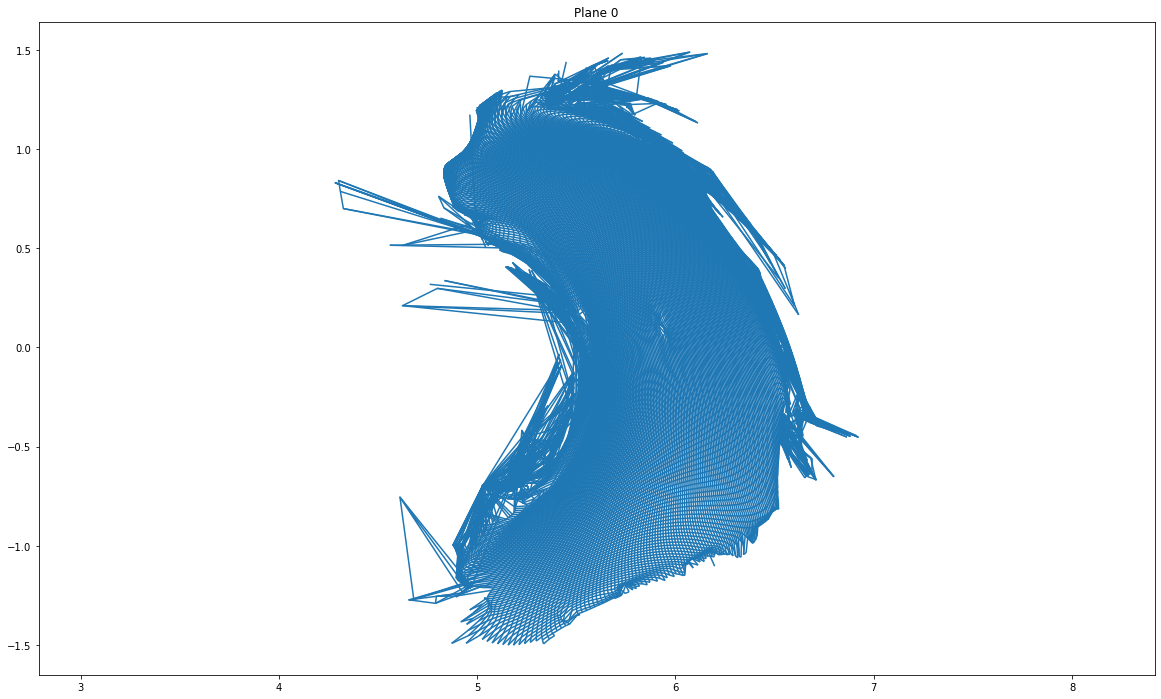

In [14]:
section1 = mData.sections[0]

r = np.asarray(section1.r)
z = np.asarray(section1.z)

def plot_grid(x,y, ax=None, **kwargs):
    from matplotlib.collections import LineCollection
    
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

for i in [(len(r) - 1) // 2, (len(r) - 1) // 2 + 1, 0, -1]:
    plt.figure(figsize = (20, 12))
    plot_grid(r[i], z[i])
    plt.axis('equal')
    if i == (len(r) - 1) // 2:
        plt.title("Plane {} (mapping plane)".format(i+1))
    else:
        plt.title("Plane {}".format(i + 1))
    plt.show()

In [15]:
rStart = np.linspace(4.4, 4.7, 40)
phi = np.radians(72 * 0 + 36)
xStart = np.cos(phi) * rStart
yStart = np.sin(phi) * rStart
zStart = 0 * rStart

pStart = [xStart, yStart, zStart]
#xStart = np.linspace([5.5, 0, 0], [5.8, 0, 0], 40, axis = 1)

pc = fsc.flt.poincareInPhiPlanes(pStart, field, [0, np.pi, np.radians(200.8)], 2000, distanceLimit = 1e7, stepSize = 0.25, mapping = mapping, geometry = geometry)

In [16]:
np.isfinite(pc[0]).sum()

198218

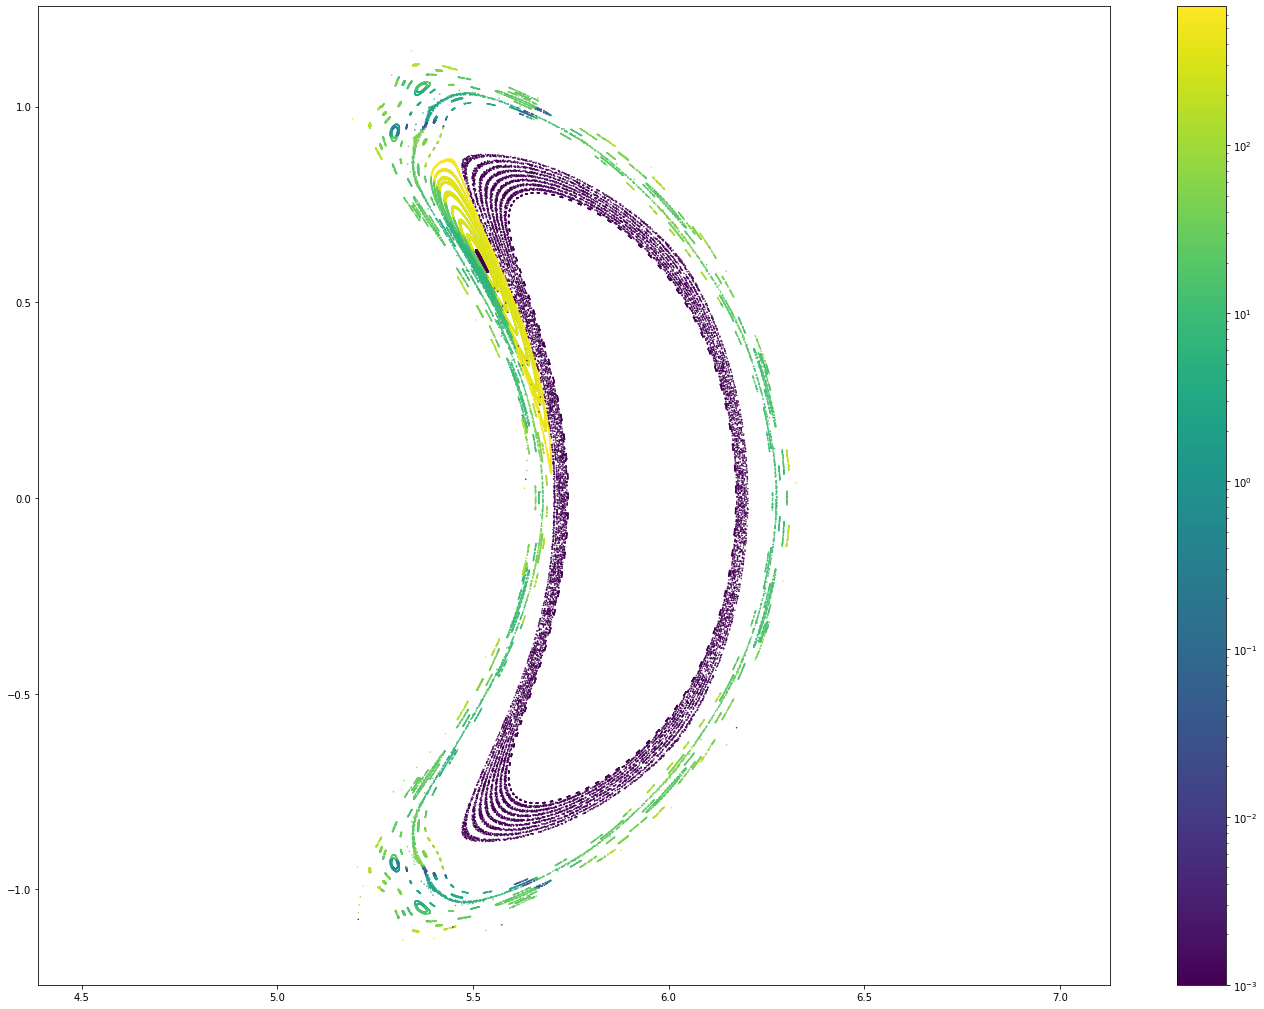

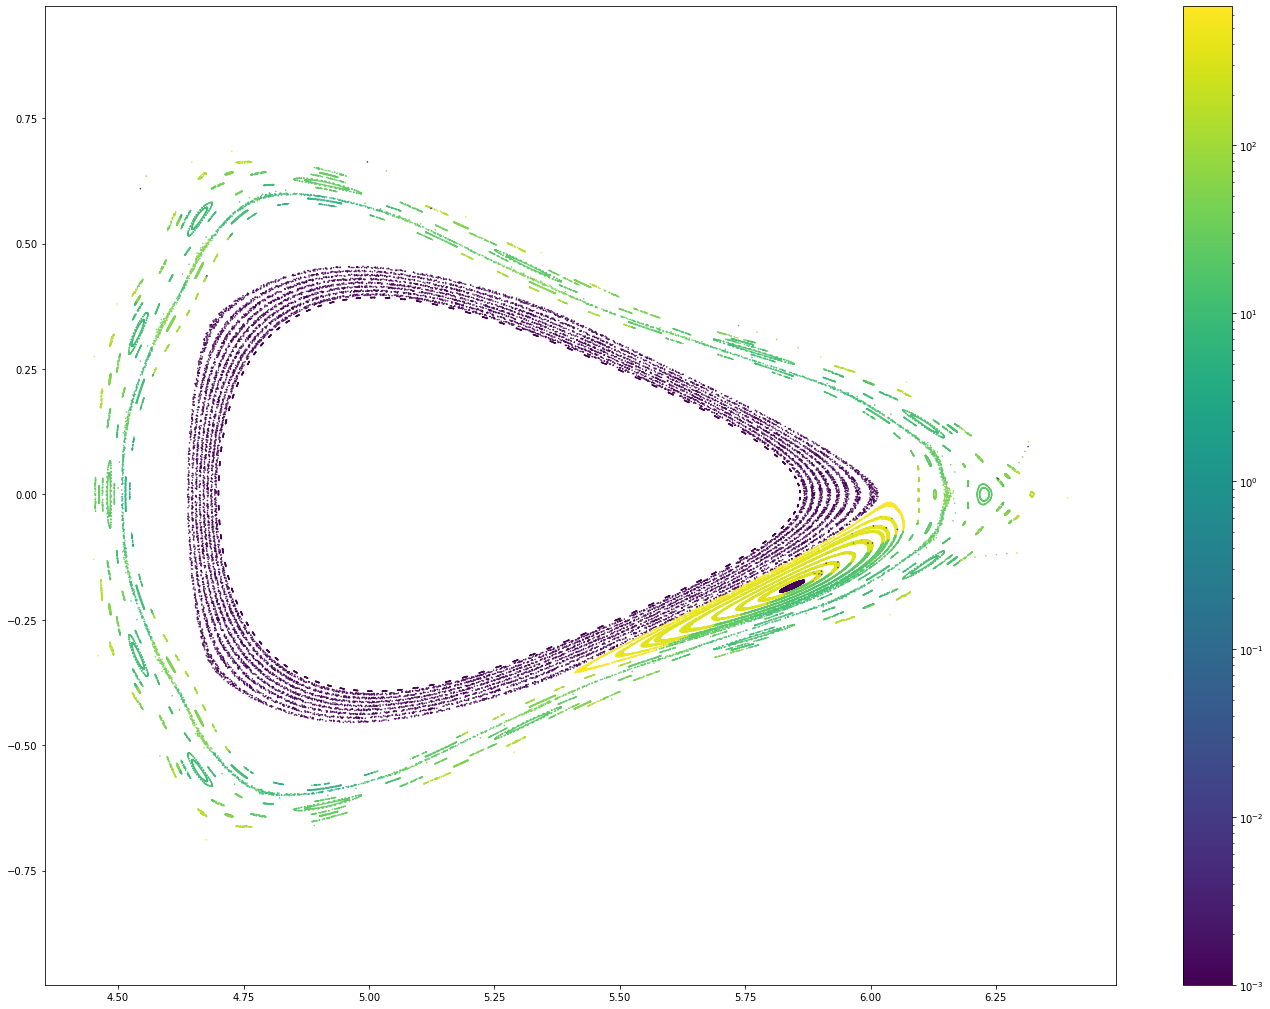

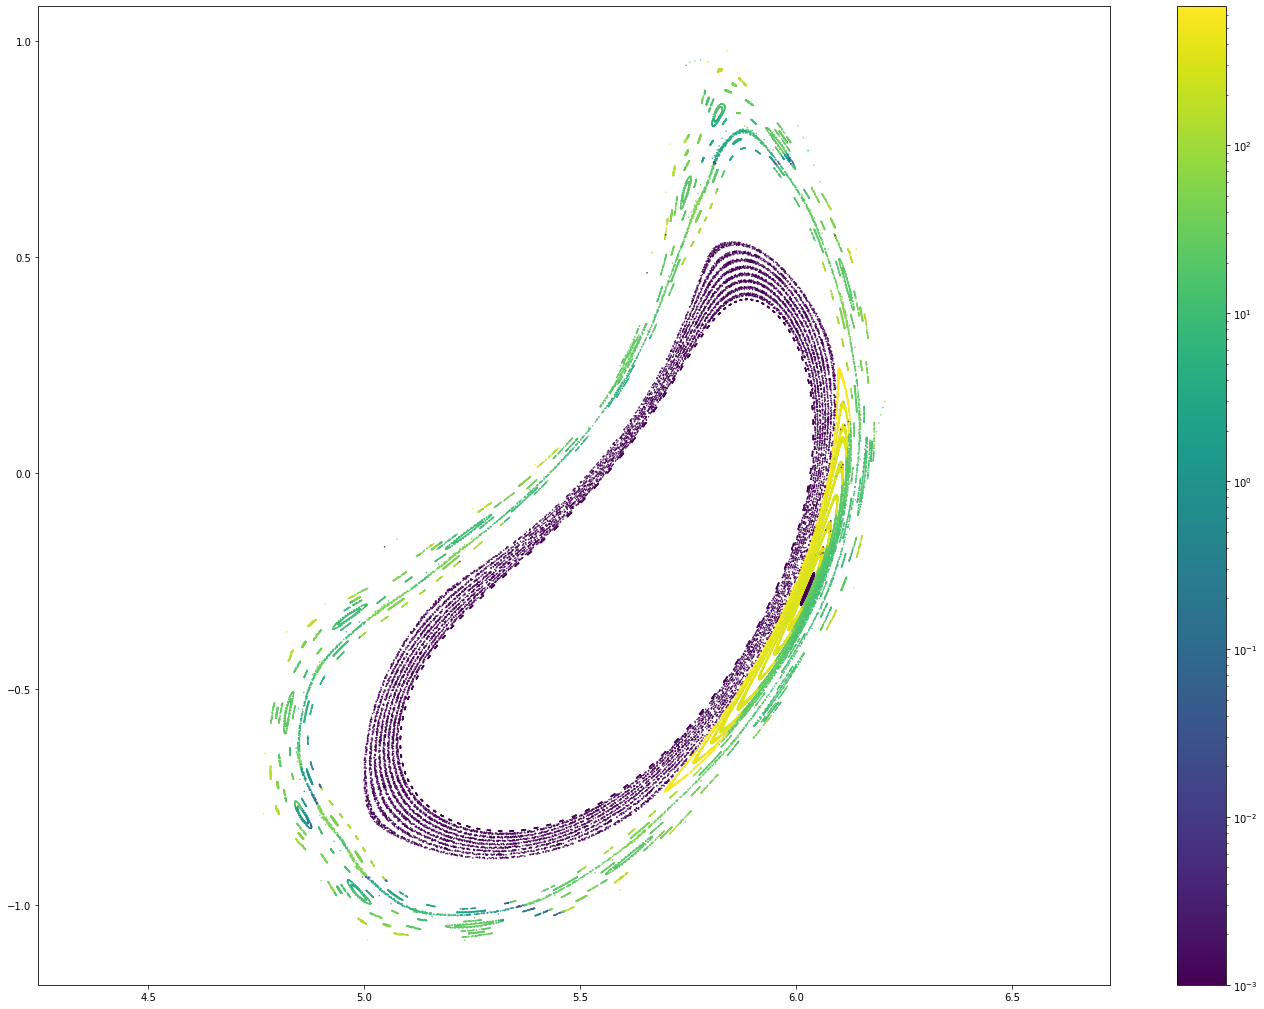

In [17]:
from matplotlib.colors import LogNorm

x, y, z, lF, lB = pc
r = np.sqrt(x**2 + y**2)

for i in range(len(x)):
    plt.figure(figsize = (24, 18))
    plt.scatter(r[i], z[i], c = np.maximum(lF + lB, 0.001)[i], marker = '.', s = 1, norm = LogNorm())
    plt.colorbar()
    plt.axis('equal')
#plt.xlim(4.5, 4.75)
#plt.ylim(-0.4, 0.4lB

In [17]:
r = np.linspace(4.5, 4.75, 100)
z = np.linspace(-0.4, 0.4, 160)

rg, zg = np.meshgrid(r, z, indexing = 'ij')
xg = -rg
yg = 0 * rg

def calc_len(factor):
    return fsc.flt.connectionLength([xg, yg, zg], field * factor, geometry, grid = grid, mapping = mapping, distanceLimit = 1e3, stepSize = 0.1)

import time
start = time.time()
lc = calc_len(1) + calc_len(-1)
end = time.time()
print(end - start)

312.19163274765015


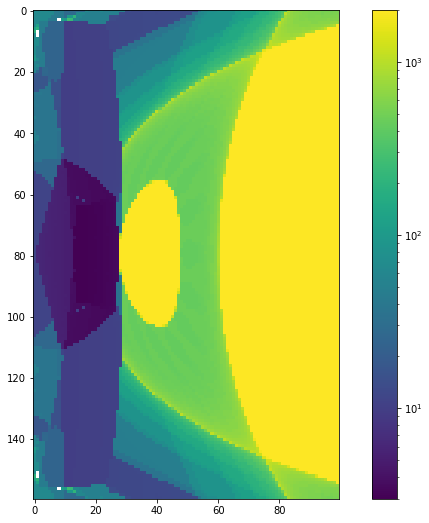

In [19]:
from matplotlib.colors import LogNorm
plt.figure(figsize = (12, 9))
plt.imshow(lc.T, norm = LogNorm())
plt.colorbar()

In [7]:
r = np.linspace(5.95, 6.1, 120)
z = np.linspace(-0.25, -0.1, 120)
phi = np.radians(200.8)

rg, zg = np.meshgrid(r, z, indexing = 'ij')
xg = np.cos(phi) * rg
yg = np.sin(phi) * rg

def calc_len(factor):
    return fsc.flt.connectionLength([xg, yg, zg], field * factor, geometry, grid = grid, mapping = mapping, distanceLimit = 1e3, stepSize = 0.1)

import time
start = time.time()
lc = calc_len(1) + calc_len(-1)
end = time.time()
print(end - start)

535.5173184871674


(5.9, 6.2, -0.4, 0.0)

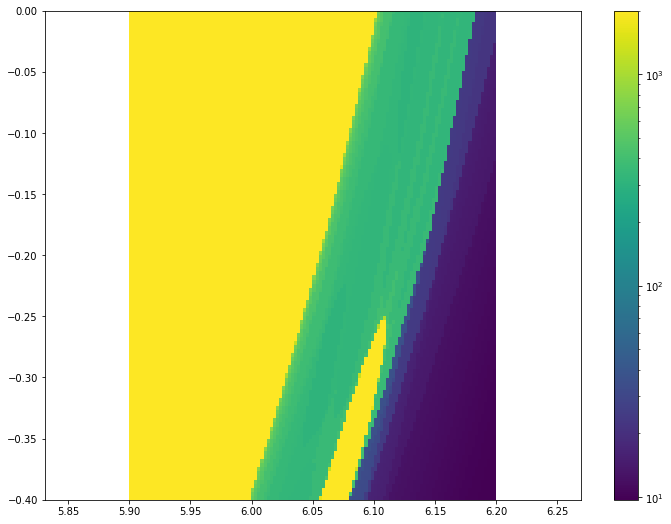

In [8]:
from matplotlib.colors import LogNorm
plt.figure(figsize = (12, 9))
plt.imshow(lc.T, norm = LogNorm(), origin = "lower", extent = [5.9, 6.2, -0.4, 0])
plt.colorbar()
plt.axis('equal')